## Imports

In [30]:
!pip install -r requirements.txt

In [31]:
# !pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug
# !pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
# !pip install py7zr #Sur colab, sinon bug
# !pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

Cloning into 'cartogether'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 224 (delta 57), reused 44 (delta 23), pack-reused 108
Receiving objects: 100% (224/224), 482.99 KiB | 2.78 MiB/s, done.
Resolving deltas: 100% (93/93), done.
/home/onyxia/work/30daysmapchallenge2022/day20_favourite/cartogether/cartogether
Processing /home/onyxia/work/30daysmapchallenge2022/day20_favourite/cartogether/cartogether
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cartiflette: filename=cartiflette-0.0.1-py3-none-any.whl size=18118 sha256=93c54818cae40d62d0f1854926491f5603ac4f25f9d4b0114049af90d2a4f60a
  Stored in directory: /tmp/pip-ephem-wheel-cache-gp_exfv_/wheels/01/75/ec/dbc453a14eb6d3b7ab95724c925695909d6b9d9e43fff41dcb
Successfully built cartiflette
  Attempting uninstall: cartiflette


In [32]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import time
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette.download import get_vectorfile_ign

In [33]:
import functions as fc

In [34]:
url_ffe = 'http://www.echecs.asso.fr/'
suffix_all_clubs = 'ListeClubs.aspx?Action=CLUBCOMITE&ComiteRef='
suffix_all_players_club = 'ListeJoueurs.aspx?Action=JOUEURCLUBREF&ClubRef='

In [35]:
headers = {
    'User-Agent': 'Antoine Palazzolo - INSEE - Collect data to make maps about elos in France',
    'From': 'antoine.palazzolo@insee.fr'  # This is another valid field
}

## Faire liste clubs

In [36]:
def get_infos_club_from_row(row):
    fields = row.find_all('td')
    departement = fields[0].text.strip()
    commune = fields[1].text.strip()
    club = fields[2].text.strip()
    try:
        suffix_club = fields[2].find('a').get('href')
        ref_club = ''.join(c for c in suffix_club if c.isdigit())
    except:
        suffix_club = None
        ref_club = None
    return [club, ref_club, suffix_club, commune, departement]

In [50]:
def get_all_clubs_in_departement(departement):
    
    liste_clubs_departement = []
    if str(departement).isnumeric():
        departement = "{:02d}".format(int(departement))
    
    url = url_ffe + suffix_all_clubs + departement
    request_text = requests.get(url, headers=headers).text
    soup = BeautifulSoup(request_text, 'html.parser')
    
    try:
        zone = soup.find('div', {'class':'page-mid'})
        tableau = zone.find('table')
        rows = tableau.find_all('tr')

        for i in range(1,len(rows)):
            liste_clubs_departement.append(get_infos_club_from_row(rows[i]))
    except:
        pass
    return liste_clubs_departement

In [51]:
def get_all_clubs_france():
    liste_clubs = []
    for departement in tqdm(range(100)):
        liste_clubs += get_all_clubs_in_departement(departement)
        time.sleep(1)
    liste_clubs += get_all_clubs_in_departement('2A')
    liste_clubs += get_all_clubs_in_departement('2B')
    return liste_clubs

In [52]:
liste_clubs = get_all_clubs_france()

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [53]:
df_clubs = pd.DataFrame(liste_clubs, columns = ['club_name', 'club_reference', 'suffix_url', 'commune', 'departement'])

In [54]:
df_clubs

,club_name,club_reference,suffix_url,commune,departement
0,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
1,Club d'Echecs de Belley,3232,FicheClub.aspx?Ref=3232,BELLEY,01
2,Cercle d'Echecs Bressan,1168,FicheClub.aspx?Ref=1168,BOURG EN BRESSE,01
3,La Tour de la Dombes,1171,FicheClub.aspx?Ref=1171,CHATILLON SUR CHALARONNE,01
4,Amicale Echecs,2725,FicheClub.aspx?Ref=2725,GEX,01
...,...,...,...,...,...
827,Pion 2B,3235,FicheClub.aspx?Ref=3235,Biguglia,2B
828,Balagna Chess Club,1875,FicheClub.aspx?Ref=1875,CALVI,2B
829,Associu di i Scacchi di U Centru,2030,FicheClub.aspx?Ref=2030,CORTE,2B
830,Club d'Echecs de Casinca,1751,FicheClub.aspx?Ref=1751,PENTA DI CASINCA,2B


In [55]:
nombres_clubs = df_clubs.groupby('departement', as_index=False)['club_name'].count().sort_values(by='club_name', ascending=False)
nombres_clubs

,departement,club_name
73,75,36
65,67,30
57,59,29
66,68,22
67,69,22
...,...,...
27,2A,2
14,15,1
56,58,1
42,43,1


## Faire liste joueurs

In [56]:
def get_infos_player_from_row(row):
    fields = row.find_all('td')
    elo_lent = int(''.join(c for c in fields[4].text if c.isdigit()))
    elo_rapide = int(''.join(c for c in fields[5].text if c.isdigit()))
    elo_blitz = int(''.join(c for c in fields[6].text if c.isdigit()))
    category = fields[7].text.strip()
    age = category[:3]
    sex = category[-1]
    club_name = fields[9].text.strip()
    return [elo_lent, elo_rapide, elo_blitz, category, age, sex, club_name]

In [57]:
def get_all_players_in_club(ref_club):
    
    liste_players_clubs = []
    
    url = url_ffe + suffix_all_players_club + str(ref_club)
    request_text = requests.get(url, headers=headers).text
    soup = BeautifulSoup(request_text, 'html.parser')
    
    try:
        zone = soup.find('div', {'class':'page-mid'})
        tableau = zone.find('table')
        rows = tableau.find_all('tr')
        
        for i in range(1,len(rows)):
            liste_players_clubs.append(get_infos_player_from_row(rows[i]))
    except:
        pass
    return liste_players_clubs

In [58]:
def get_all_players_france():
    liste_players = []
    for club in tqdm(df_clubs['club_reference'].drop_duplicates()):
        liste_players += get_all_players_in_club(club)
        time.sleep(1)
    return liste_players

In [59]:
liste_players = get_all_players_france()

100%|██████████| 832/832 [16:38<00:00,  1.20s/it]


In [60]:
df_players = pd.DataFrame(liste_players, columns = ['elo_lent', 'elo_rapide', 'elo_blitz', 'category', 'age', 'sex', 'club_name'])

In [61]:
nombres_joueurs = df_players.groupby('club_name', as_index=False)['elo_lent'].count().sort_values(by='elo_lent', ascending=False)
nombres_joueurs

,club_name,elo_lent
0,"""Le Gambit ""de Muret",40
400,Echiquier Scéen - Sceaux,40
436,Echiquier de l'Erdre,40
435,Echiquier de l'Armagnac,40
434,Echiquier de l'ABC Pays de Vannes,40
...,...,...
481,Evry Grand Roque,2
261,Club d'Echecs de la Tour Houdanaise,2
770,Sezanne Echecs,1
727,Paris Top Chess Club,1


## Jointure

In [74]:
df = pd.merge(df_players, df_clubs, on='club_name')
df_adultes = df[df['age'].isin(['Sen', 'Sep', 'Vet'])]

In [76]:
df

,elo_lent,elo_rapide,elo_blitz,category,age,sex,club_name,club_reference,suffix_url,commune,departement
0,1009,960,960,PouM,Pou,M,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
1,1199,1199,1199,SenF,Sen,F,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
2,1199,1260,1260,BenM,Ben,M,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
3,1009,799,799,PouM,Pou,M,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
4,1199,999,999,BenF,Ben,F,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
...,...,...,...,...,...,...,...,...,...,...,...
21194,1199,1199,1199,VetF,Vet,F,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B
21195,1009,799,799,PouF,Pou,F,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B
21196,1009,799,799,PpoM,Ppo,M,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B
21197,1009,799,799,PouM,Pou,M,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B


In [77]:
df_adultes

,elo_lent,elo_rapide,elo_blitz,category,age,sex,club_name,club_reference,suffix_url,commune,departement
1,1199,1199,1199,SenF,Sen,F,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
7,1202,1219,1219,SepM,Sep,M,La Tour de Bage,2833,FicheClub.aspx?Ref=2833,BAGE LA VILLE,01
12,1370,1365,1365,VetM,Vet,M,Club d'Echecs de Belley,3232,FicheClub.aspx?Ref=3232,BELLEY,01
13,1399,1280,1280,SepM,Sep,M,Club d'Echecs de Belley,3232,FicheClub.aspx?Ref=3232,BELLEY,01
14,1199,1199,1199,VetM,Vet,M,Club d'Echecs de Belley,3232,FicheClub.aspx?Ref=3232,BELLEY,01
...,...,...,...,...,...,...,...,...,...,...,...
21170,1199,1199,1199,SenM,Sen,M,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B
21174,1384,1403,1391,SenM,Sen,M,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B
21175,1199,1199,1199,SenM,Sen,M,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B
21177,1537,1410,1510,VetM,Vet,M,Echecs Club du Fium'Orbu,1851,FicheClub.aspx?Ref=1851,PRUNELLI DI FIUMORBO,2B


In [79]:
df_departements = df.groupby('departement', as_index=False)['elo_lent'].mean().sort_values(by='elo_lent')
df_departements

,departement,elo_lent
42,43,1166.875000
51,53,1178.636943
28,2B,1183.321429
8,09,1185.776471
71,73,1186.696203
...,...,...
60,62,1388.004255
68,70,1422.923077
11,12,1430.048780
84,86,1436.569767


In [95]:
df_adultes_departements = df_adultes.groupby('departement', as_index=False)['elo_lent'].mean().sort_values(by='elo_lent')
df_adultes_departements

,departement,elo_lent
71,73,1274.000000
51,53,1292.753846
53,55,1314.850000
39,40,1318.855263
34,35,1340.652015
...,...,...
22,25,1589.142857
49,51,1601.860465
84,86,1614.076923
7,08,1615.870968


## Create map

In [65]:
france = get_vectorfile_ign(
  level = "COMMUNE",
  field = "metropole",
  source = "COG",
  provider="opendatarchives"
  )

opendatarchives
COG


Downloading: 100%|██████████| 244M/244M [02:22<00:00, 1.79MiB/s] 
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [66]:
carte_departements = france.dissolve(by='INSEE_DEP', aggfunc='sum')
carte_departements

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


,geometry,POPULATION
INSEE_DEP,,
01,"POLYGON ((843069.400 6536413.800, 843056.900 6...",652432
02,"POLYGON ((718664.700 6873887.300, 718653.100 6...",531345
03,"POLYGON ((673871.400 6559735.100, 673865.200 6...",335975
04,"POLYGON ((922047.200 6296459.200, 922042.000 6...",164308
05,"POLYGON ((920018.300 6349446.500, 920013.800 6...",141220
...,...,...
91,"POLYGON ((622877.700 6801316.200, 622850.700 6...",1301659
92,"POLYGON ((643324.900 6852986.700, 643317.100 6...",1624357
93,"POLYGON ((657256.900 6861184.400, 657195.100 6...",1644903


In [90]:
df_departements.rename(columns={'departement':'INSEE_DEP'}, inplace=True)
carte_departements_avec_elo = pd.merge(carte_departements, df_departements, on='INSEE_DEP')

In [96]:
df_adultes_departements.rename(columns={'departement':'INSEE_DEP', 'elo_lent':'elo_lent_adultes'}, inplace=True)
carte_departements_avec_elo = pd.merge(carte_departements_avec_elo, df_adultes_departements, on='INSEE_DEP')

In [97]:
carte_departements_avec_elo

,INSEE_DEP,geometry,POPULATION,elo_lent,elo_lent_adulte,elo_lent_adultes
0,01,"POLYGON ((843069.400 6536413.800, 843056.900 6...",652432,1245.074303,1417.690323,1417.690323
1,02,"POLYGON ((718664.700 6873887.300, 718653.100 6...",531345,1251.507812,1374.444444,1374.444444
2,03,"POLYGON ((673871.400 6559735.100, 673865.200 6...",335975,1322.452632,1439.161290,1439.161290
3,04,"POLYGON ((922047.200 6296459.200, 922042.000 6...",164308,1263.972603,1391.222222,1391.222222
4,05,"POLYGON ((920018.300 6349446.500, 920013.800 6...",141220,1360.135593,1483.666667,1483.666667
...,...,...,...,...,...,...
89,91,"POLYGON ((622877.700 6801316.200, 622850.700 6...",1301659,1254.989899,1485.623457,1485.623457
90,92,"POLYGON ((643324.900 6852986.700, 643317.100 6...",1624357,1275.268446,1530.679688,1530.679688
91,93,"POLYGON ((657256.900 6861184.400, 657195.100 6...",1644903,1243.126362,1547.601307,1547.601307
92,94,"POLYGON ((653682.900 6847456.200, 653682.400 6...",1407124,1230.328685,1488.483516,1488.483516


<AxesSubplot: title={'center': 'Elo moyen par département en France métropolitaine'}>

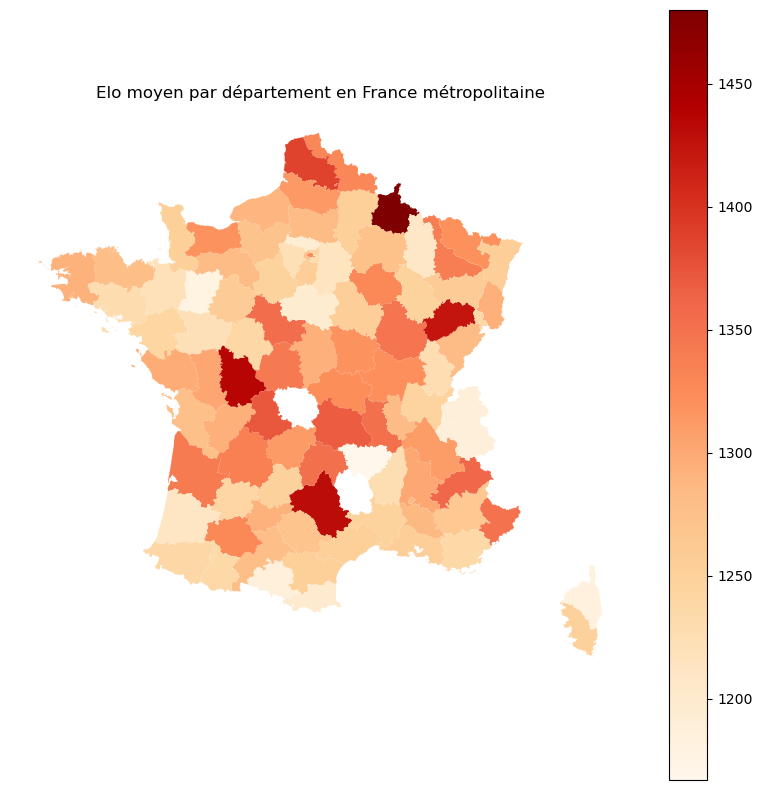

In [86]:
fig,ax = plt.subplots(figsize=(10, 10))
carte_departements_avec_elo.dissolve(by='INSEE_DEP', aggfunc='sum').plot(ax = ax, column = "elo_lent", legend=True, cmap='OrRd')
plt.title("Elo moyen par département en France métropolitaine")
ax.set_axis_off()
ax

<AxesSubplot: title={'center': 'Elo moyen par département chez les + de 21 ans, en France métropolitaine'}>

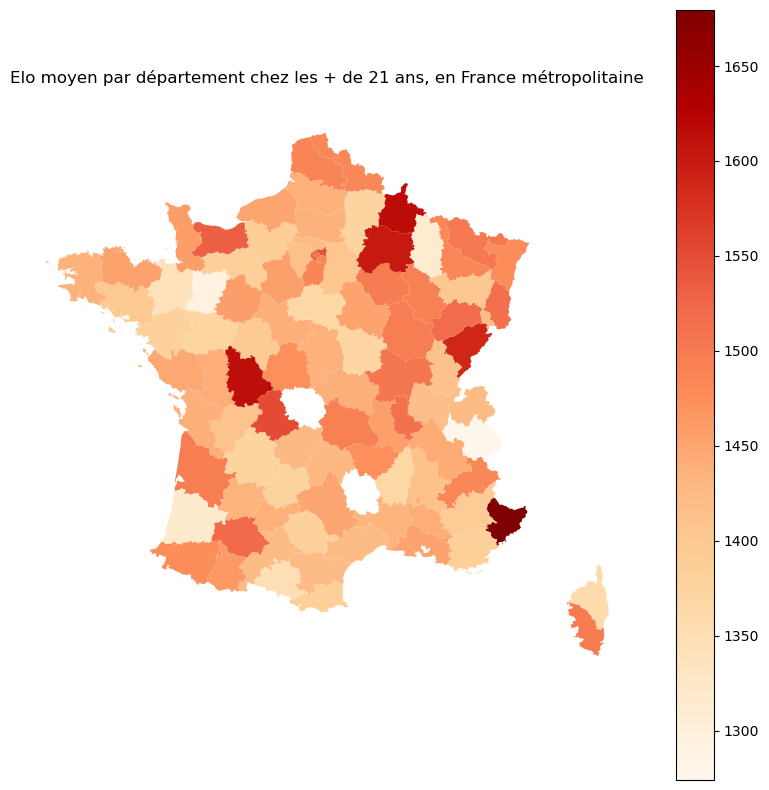

In [99]:
fig,ax = plt.subplots(figsize=(10, 10))
carte_departements_avec_elo.dissolve(by='INSEE_DEP', aggfunc='sum').plot(ax = ax, column = "elo_lent_adultes", legend=True, cmap='OrRd')
plt.title("Elo moyen par département chez les + de 21 ans, en France métropolitaine")
ax.set_axis_off()
ax